<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li><li><span><a href="#Municipios" data-toc-modified-id="Municipios-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Municipios</a></span></li><li><span><a href="#Manzanas-zonas-metropolitanas" data-toc-modified-id="Manzanas-zonas-metropolitanas-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Manzanas zonas metropolitanas</a></span></li><li><span><a href="#Población-por-zonas-metropolitanas" data-toc-modified-id="Población-por-zonas-metropolitanas-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Población por zonas metropolitanas</a></span></li><li><span><a href="#Ozono" data-toc-modified-id="Ozono-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Ozono</a></span></li></ul></li><li><span><a href="#Georreferenciar-estaciones" data-toc-modified-id="Georreferenciar-estaciones-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Georreferenciar estaciones</a></span></li></ul></div>

In [1]:
import pandas as pd
import geopandas as gpd
from joblib import Parallel, delayed
import numpy as np
import json
from pathlib import Path
import altair as alt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Point
import mplleaflet

pd.options.mode.chained_assignment = None

%matplotlib inline

# Init data

## Estaciones

In [2]:
estaciones = pd.read_csv('/data_estaciones_sinaica.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 8)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
0,5b8850e3e2705c1932e82ff8,21.873311,-102.320803,31,CBTIS,CBT,30,2018-08-30 20:17:39.218
1,5b8850e3e2705c1932e82ff9,21.846392,-102.288431,32,Secretaría de Medio Ambiente,SMA,30,2018-08-30 20:17:39.218
2,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218
3,5b8850e3e2705c1932e82ffb,31.859917,-116.593722,36,Secundaria,SPABC20,31,2018-08-30 20:17:39.218
4,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218


## Data Mediciones

In [3]:
mediciones = pd.read_csv('/data_mediciones_todas_estaciones.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [4]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
estaciones_ciudad = estaciones_ciudad.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                            on='estacionesid')
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(121, 6)


,city,state,estacionesid,lat,long,nombre
0,Durango,Durango,58,24.034472,-104.645028,ITD
1,Durango,Durango,59,24.051556,-104.611361,IPN
2,Durango,Durango,60,24.026778,-104.692975,SRNyMA
3,Gómez Palacio,Durango,65,25.551222,-103.502528,Campestre
4,Celaya,Guanajuato,68,20.517500,-100.815556,Policía


In [5]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

## Municipios

- Los descargué de acá: http://www.beta.inegi.org.mx/app/biblioteca/ficha.html?upc=702825217341
- Se tiene que preprocesar, ver: https://stackoverflow.com/questions/47243879/brecode-from-ansi-1252-to-utf-8-failed-with-the-error-invalid-argument-geo
- Usando la respuesta anterior yo usé: `ogr2ogr muns.shp areas_geoestadisticas_municipales.shp -lco ENCODING=UTF-8`

In [19]:
muns = gpd.read_file('/data/shapes_inegi/shapes_municipios/muns.shp', encoding='latin1')
muns['cvemun'] = muns.CVE_ENT+muns.CVE_MUN
muns.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs", inplace=True)
muns.head()

,CVE_ENT,CVE_MUN,NOM_MUN,geometry,cvemun
0,01,002,Asientos,POLYGON ((-102.0518934497553 22.29143529004646...,01002
1,01,011,San Francisco de los Romo,"POLYGON ((-102.1509958197251 22.0885897204269,...",01011
2,01,007,RincÃ³n de Romos,POLYGON ((-102.2268415996368 22.37392855034858...,01007
3,01,008,San JosÃ© de Gracia,POLYGON ((-102.4561095998072 22.32323224960183...,01008
4,01,005,JesÃºs MarÃ­a,"POLYGON ((-102.333477539963 22.05019694973148,...",01005


## Manzanas zonas metropolitanas

- Municipios por zona metropolitana sacados de acá: https://www.gob.mx/cms/uploads/attachment/file/309816/4_cuadro_8_matriz_bueno_correciones_23_de_febrero.pdf

In [37]:
guadalajara_mnz = gpd.read_file('/shapes/mnz_zonas_metro_2016/zm_Guadalajara')
toluca_mnz = gpd.read_file('/shapes/mnz_zonas_metro_2016/zm_Toluca')
monterrey_mnz = gpd.read_file('/shapes/mnz_zonas_metro_2016/zm_Monterrey')
vallemex_mnz = gpd.read_file('/shapes/mnz_zonas_metro_2016/zm_ValleMexico')

mnz_zonasMet = pd.concat([guadalajara_mnz, toluca_mnz, vallemex_mnz, monterrey_mnz])
print(mnz_zonasMet.shape)
mnz_zonasMet.head()

(306288, 6)


,cvegeo,cvemun,geometry,tipo,tipomza,zona_met
0,1410101881963800,14101,(POLYGON ((-103.2616548203058 20.6992963995447...,Caserío Disperso,NaN,Guadalajara
1,1412000560123800,14120,(POLYGON ((-103.4067395796593 20.8337961095740...,Caserío Disperso,NaN,Guadalajara
2,1410101422552800,14101,(POLYGON ((-103.2313047403976 20.5612279998585...,Caserío Disperso,NaN,Guadalajara
3,1412001530015800,14120,(POLYGON ((-103.5798034902669 20.9096736301016...,Caserío Disperso,NaN,Guadalajara
4,1409800030012800,14098,(POLYGON ((-103.4131147799056 20.5608117200612...,Caserío Disperso,NaN,Guadalajara


## Población por zonas metropolitanas 

- Obtenida de http://www.conapo.gob.mx/es/CONAPO/Proyecciones

In [43]:
conapo_mun = pd.read_csv('/conapo_municipio.csv', dtype={'cvegeo':str}, parse_dates=['fecha'])
conapo_mun = conapo_mun[conapo_mun.fecha.dt.year==2017][['cvegeo', 'total']]
conapo_mun.columns = ['cvemun', 'poblacion_total']
print(conapo_mun.shape)
conapo_mun.head()

(2457, 2)


,cvemun,poblacion_total
7,01001,886741.271100
28,01002,50584.822426
49,01003,58902.606995
70,01004,16588.044377
91,01005,115005.715906


## Ozono

In [44]:
medicion_contaminante = mediciones[mediciones.parametro=='O3']

# De acuerdo al análisis anterior, es buena idea filtrar valores demasiado grandes. Vamos a usar
# como filtro el mínimo valor de ozono para establecer calidad del aire muy mala según SEMARNAT que es 0.6 ppm
medicion_contaminante = medicion_contaminante[medicion_contaminante.valororig.between(0, 0.7)]

medicion_contaminante = medicion_contaminante.groupby('estacionesid').agg({'valororig':['mean', 'count'],
                                                                           'validoorig':'mean'}).reset_index()
medicion_contaminante.columns = ['estacionesid', 'valororig', 'num_registros', 'validoorig']

medicion_contaminante = medicion_contaminante.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                                    on='estacionesid')
medicion_contaminante = medicion_contaminante.merge(mediciones[['estacionesid', 'city']].drop_duplicates(),
                                                    on='estacionesid')

print(medicion_contaminante.shape)
medicion_contaminante.head()

(107, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
0,33,0.290461,143,1,21.883781,-102.295825,Centro,Aguascalientes
1,38,0.039118,2,1,32.631317,-115.444631,UABC,Mexicali
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
3,41,0.010098,365,1,32.603639,-115.485944,CESPM,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana


In [45]:
mask = (medicion_contaminante.num_registros>2400)
filtered_medicion = medicion_contaminante[mask]

print(filtered_medicion.shape)
filtered_medicion.head()

(96, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana
5,53,0.031892,8795,1,28.632775,-106.038867,SUR,Chihuahua
6,54,0.038020,4970,1,28.652228,-106.085358,Centro,Chihuahua
7,56,0.011542,5583,1,25.522694,-103.395806,CONALEP,Torreón


# Georreferenciar estaciones

In [34]:
aux = estaciones.merge(mediciones[['city', 'estacionesid']].drop_duplicates(), on='estacionesid')
aux = gpd.GeoDataFrame(aux)
aux['geometry'] = aux[['long', 'lat']].apply(Point, axis=1)
aux.crs = {'init' :'epsg:4326'}
aux.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs", inplace=True)
print(aux.shape)
aux.head()

(121, 10)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert,geometry,city
0,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218,POINT (-102.295825 21.883780555556),Aguascalientes
1,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218,POINT (-115.44463055556 32.631316666667),Mexicali
2,5b8850e3e2705c1932e82ffd,32.639722,-115.506389,39,COBACH,SPABC14,32,2018-08-30 20:17:39.218,POINT (-115.50638888889 32.639722222222),Mexicali
3,5b8850e3e2705c1932e82ffe,32.603639,-115.485944,41,CESPM,SPABC19,32,2018-08-30 20:17:39.218,POINT (-115.48594444444 32.60363888888899),Mexicali
4,5b8850e3e2705c1932e83003,32.529461,-116.921281,46,Laboratorio,SPABC21,35,2018-08-30 20:17:39.218,POINT (-116.92128055556 32.529461111111),Tijuana


In [32]:
estaciones_georref = gpd.sjoin(muns[['cvemun', 'geometry']], aux, op='contains')
print(estaciones_georref.shape)
estaciones_georref.head()

(121, 12)


,cvemun,geometry,index_right,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert,city
6,01001,POLYGON ((-102.1064122496705 22.06035442028542...,0,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218,Aguascalientes
6,01001,POLYGON ((-102.1064122496705 22.06035442028542...,107,5b8850e3e2705c1932e83090,21.903000,-102.284611,303,Instituto Educativo,IED,30,2018-08-30 20:17:39.226,Aguascalientes
13,02004,(POLYGON ((-117.2456542479472 32.4139023211325...,5,5b8850e3e2705c1932e83004,32.497500,-116.976944,47,La Mesa,SPABC03,35,2018-08-30 20:17:39.218,Tijuana
13,02004,(POLYGON ((-117.2456542479472 32.4139023211325...,4,5b8850e3e2705c1932e83003,32.529461,-116.921281,46,Laboratorio,SPABC21,35,2018-08-30 20:17:39.218,Tijuana
14,02002,(POLYGON ((-112.8923305416096 28.6782608390432...,3,5b8850e3e2705c1932e82ffe,32.603639,-115.485944,41,CESPM,SPABC19,32,2018-08-30 20:17:39.218,Mexicali


In [36]:
estaciones_georref.city.value_counts().head()

Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
Chihuahua           3
Name: city, dtype: int64

In [50]:
_estaciones = filtered_medicion[filtered_medicion.city.isin(['Valle de México', 'Guadalajara',
                                                             'Monterrey', 'Toluca'])].estacionesid

aux = estaciones_georref[estaciones_georref.estacionesid.isin(_estaciones)]

for c in aux.cvemun:
    try:
        val = mnz_zonasMet.loc[mnz_zonasMet.cvemun==c, 'zona_met'].unique()[0]
        aux.loc[aux.cvemun==c, 'zona_met'] = val
    except IndexError:
        pass

# La manzana que le asignamos a la estacion 301 está en la zona metro de Toluca, aunque
# en sinaica la reportan como que está en el DF.
print(aux.shape)
aux.head()

(52, 13)


,cvemun,geometry,index_right,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert,city,zona_met
265,09010,POLYGON ((-99.18905516971394 19.39559033963965...,89,5b8850e3e2705c1932e8307b,19.325278,-99.204167,259,Pedregal,PED,119,2018-08-30 20:17:39.225,Valle de México,Valle de México
266,09012,"POLYGON ((-99.19671103028183 19.3024049699653,...",73,5b8850e3e2705c1932e8306a,19.154286,-99.162778,241,Ajusco,AJU,119,2018-08-30 20:17:39.225,Valle de México,Valle de México
266,09012,"POLYGON ((-99.19671103028183 19.3024049699653,...",74,5b8850e3e2705c1932e8306b,19.272222,-99.207778,242,Ajusco Medio,AJM,119,2018-08-30 20:17:39.225,Valle de México,Valle de México
267,09015,POLYGON ((-99.12884251966094 19.46226699987632...,82,5b8850e3e2705c1932e83074,19.411667,-99.152222,251,Hospital General de México,HGM,119,2018-08-30 20:17:39.225,Valle de México,Valle de México
268,09017,POLYGON ((-99.10889128964793 19.45287855031421...,86,5b8850e3e2705c1932e83078,19.424722,-99.119722,256,Merced,MER,119,2018-08-30 20:17:39.225,Valle de México,Valle de México


In [51]:
mask = (mediciones.parametro=='O3') & (mediciones.estacionesid.isin(_estaciones))

mediciones_zonasMet = mediciones[mask].merge(aux[['estacionesid', 'cvemun', 'zona_met']], on='estacionesid')
print(mediciones_zonasMet.shape)
mediciones_zonasMet.head()

(251605, 10)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,cvemun,zona_met
0,Guadalajara,101,2018-01-01,1,O3,Jalisco,1,0.008105,14120,Guadalajara
1,Guadalajara,101,2018-01-01,2,O3,Jalisco,1,0.007569,14120,Guadalajara
2,Guadalajara,101,2018-01-01,3,O3,Jalisco,1,0.001316,14120,Guadalajara
3,Guadalajara,101,2018-01-01,4,O3,Jalisco,1,0.002411,14120,Guadalajara
4,Guadalajara,101,2018-01-01,5,O3,Jalisco,1,0.000932,14120,Guadalajara


In [56]:
pob_zonasMet = conapo_mun.merge(mnz_zonasMet[['cvemun', 'zona_met']].drop_duplicates(), on='cvemun')
pob_zonasMet = pob_zonasMet.groupby('zona_met').poblacion_total.sum().reset_index()
pob_zonasMet

,zona_met,poblacion_total
0,Guadalajara,4.909287e+06
1,Monterrey,4.603254e+06
2,Toluca,2.260149e+06
3,Valle de México,2.165067e+07


In [58]:
mediciones_100mil = mediciones_zonasMet.merge(pob_zonasMet, on='zona_met')
mediciones_100mil['valor_100mil'] = 1e5*mediciones_100mil.valororig/mediciones_100mil.poblacion_total
print(mediciones_100mil.shape)
mediciones_100mil.head()

(251605, 12)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,cvemun,zona_met,poblacion_total,valor_100mil
0,Guadalajara,101,2018-01-01,1,O3,Jalisco,1,0.008105,14120,Guadalajara,4.909287e+06,0.000165
1,Guadalajara,101,2018-01-01,2,O3,Jalisco,1,0.007569,14120,Guadalajara,4.909287e+06,0.000154
2,Guadalajara,101,2018-01-01,3,O3,Jalisco,1,0.001316,14120,Guadalajara,4.909287e+06,0.000027
3,Guadalajara,101,2018-01-01,4,O3,Jalisco,1,0.002411,14120,Guadalajara,4.909287e+06,0.000049
4,Guadalajara,101,2018-01-01,5,O3,Jalisco,1,0.000932,14120,Guadalajara,4.909287e+06,0.000019


Text(0,0.5,'ppm')

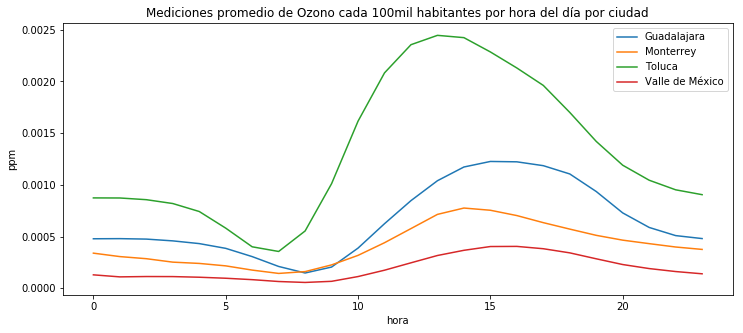

In [59]:
for i, g in mediciones_100mil.groupby('city'):
    g.groupby('hora').valor_100mil.mean().plot(figsize=(12, 5), label=i, legend=True)
    
plt.title('Mediciones promedio de Ozono cada 100mil habitantes por hora del día por ciudad')
plt.ylabel('ppm')